In [1]:
import json
import math
import random
from collections import defaultdict
from itertools import count

import numpy as np
import gymnasium as gym
from gymnasium.spaces import Discrete
import matplotlib.pyplot as plt

import games

## Q-Learning & SARSA

In [2]:
class QTable:
    def __init__(self, alpha=0.05, default_q_value=0.0):
        self.qtable = defaultdict(lambda: default_q_value)
        self.alpha = alpha

    """ Update the Q-value of (state, action) by delta """
    def update(self, state, action, delta):
        self.qtable[(state, action)] = self.qtable[(state, action)] + self.alpha * delta

    """ Get a Q value for a given state-action pair """
    def get_q_value(self, state, action):
        return self.qtable[(state, action)]
    
    """ Return the action with the maximum Q-value """
    def get_argmax_q(self, state, actions):
        (argmax_q, max_q) = self.get_max_pair(state, actions)
        return argmax_q
    
    """ Return the maximum Q-value in this Q-function """
    def get_max_q(self, state, actions):
        (argmax_q, max_q) = self.get_max_pair(state, actions)
        return max_q
    
    """ Return a pair containing the action and Q-value, where the
        action has the maximum Q-value in state
    """
    def get_max_pair(self, state, actions):
        arg_max_q = None
        max_q = float("-inf")
        for action in range(actions.start, actions.n):
            value = self.get_q_value(state, action)
            if max_q < value:
                arg_max_q = action
                max_q = value
        return (arg_max_q, max_q)     

    """ Save a policy to a specified filename """
    def save(self, filename):
        with open(filename, "w") as file:
            serialised = {str(key): value for key, value in self.qtable.items()}
            json.dump(serialised, file)  
    
    """ Load a policy from a specified filename """
    def load(self, filename, default=0.0):
        with open(filename, "r") as file:
            serialised = json.load(file)
            self.qtable = defaultdict(
                lambda: default,
                {tuple(eval(key)): value for key, value in serialised.items()},
            )
            

class EpsilonGreedy:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        
    def reset(self):
        pass
    
    def select(self, state, actions, qfunction):
        if random.random() < self.epsilon:
            return actions.sample()
        else:
            return qfunction.get_argmax_q(state, actions)


class EpsilonDecreasing:
    def __init__(self, epsilon=1.0, alpha=0.999, lower_bound=0.1):
        self.epsilon_greedy_bandit = EpsilonGreedy(epsilon)
        self.initial_epsilon = epsilon
        self.alpha = alpha
        self.lower_bound = lower_bound

    def reset(self):
        self.epsilon_greedy_bandit = EpsilonGreedy(self.initial_epsilon)

    def select(self, state, actions, qfunction):
        result = self.epsilon_greedy_bandit.select(state, actions, qfunction)
        self.epsilon_greedy_bandit.epsilon = max(
            self.epsilon_greedy_bandit.epsilon * self.alpha, self.lower_bound
        )
        return result
    

class UpperConfidenceBounds:
    def __init__(self):
        # total number of selections
        self.total = 0
        # number of times each action has been chosen
        self.times_selected = {}
    
    def reset(self):
        self.total = 0
        self.times_selected = {}
    
    def select(self, state, actions, qfunction):
        # First execute each action on time
        for action in range(actions.start, actions.n):
            if action not in self.times_selected.keys():
                self.times_selected[action] = 1
                self.total += 1
                return action

        max_actions = []
        max_value = float('-inf')
        for action in range(actions.start, actions.n):
            value = qfunction.get_q_value(state, action) + math.sqrt(
                (2 * math.log(self.total)) / self.times_selected[action]
            )
            if value > max_value:
                max_actions = [action]
                max_value = value
            elif value == max_value:
                max_actions += [action]
        
        # For multiple actions with highest value, choose one randomly
        result = random.choice(max_actions)
        self.times_selected[result] += 1
        self.total += 1
        return result


class QLearning:
    def __init__(self, env, bandit, qfunction, gamma=0.9):
        self.env = env
        self.bandit = bandit
        self.qfunction = qfunction
        self.gamma = gamma
    
    def execute(self, episodes=2000):
        rewards = []
        for episode in range(episodes):
            observation, info = self.env.reset(seed=1)
            state = tuple(np.concatenate([observation['agent'], observation['target']]))
            actions = self.env.action_space
            action = self.bandit.select(state, actions, self.qfunction)
            episode_reward = 0.0
            for step in count():
                (next_observation, reward, terminated, truncated, info) = self.env.step(action)             
                next_state = tuple(
                    np.concatenate(
                        [next_observation['agent'], next_observation['target']]
                        )
                    )
                next_action = self.bandit.select(next_state, actions, self.qfunction)
                delta = self.get_delta(state, action, reward, next_state, next_action)
                self.qfunction.update(state, action, delta)
                state = next_state
                action = next_action
                episode_reward += reward * (self.gamma ** step)
                if terminated or truncated:
                    break
            rewards.append(episode_reward)
        return rewards
    
    def get_delta(self, state, action, reward, next_state, next_action):
        q_value = self.qfunction.get_q_value(state, action)
        next_state_value = self.state_value(next_state, next_action)
        delta = reward + self.gamma * next_state_value - q_value
        return delta
    
    def state_value(self, state, action):
        actions = self.env.action_space
        max_q_value = self.qfunction.get_max_q(state, actions)
        return max_q_value
    

class SARSA:
    def __init__(self, env, bandit, qfunction, gamma=0.9):
        self.env = env
        self.bandit = bandit
        self.qfunction = qfunction
        self.gamma = gamma
    
    def execute(self, episodes=2000):
        rewards = []
        for episode in range(episodes):
            observation, info = self.env.reset(seed=1)
            state = tuple(np.concatenate([observation['agent'], observation['target']]))
            actions = self.env.action_space
            action = self.bandit.select(state, actions, self.qfunction)
            episode_reward = 0.0
            for step in count():
                (next_observation, reward, terminated, truncated, info) = self.env.step(action)             
                next_state = tuple(
                    np.concatenate(
                        [next_observation['agent'], next_observation['target']]
                        )
                    )
                next_action = self.bandit.select(next_state, actions, self.qfunction)
                delta = self.get_delta(state, action, reward, next_state, next_action)
                self.qfunction.update(state, action, delta)
                state = next_state
                action = next_action
                episode_reward += reward * (self.gamma ** step)
                if terminated or truncated:
                    break
            rewards.append(episode_reward)
        return rewards
    
    def get_delta(self, state, action, reward, next_state, next_action):
        q_value = self.qfunction.get_q_value(state, action)
        next_state_value = self.state_value(next_state, next_action)
        delta = reward + self.gamma * next_state_value - q_value
        return delta
    
    def state_value(self, state, action):
        actions = self.env.action_space
        max_q_value = self.qfunction.get_q_value(state, action)
        return max_q_value


def get_ema(rewards, smoothing_factor=0.9):
    smoothed_rewards = []
    for reward in rewards:
        if smoothed_rewards == []:
            smoothed_rewards = [reward]
        else:
            smoothed_rewards += [
                smoothed_rewards[-1] * smoothing_factor
                + reward * (1 - smoothing_factor)
            ]
    return smoothed_rewards

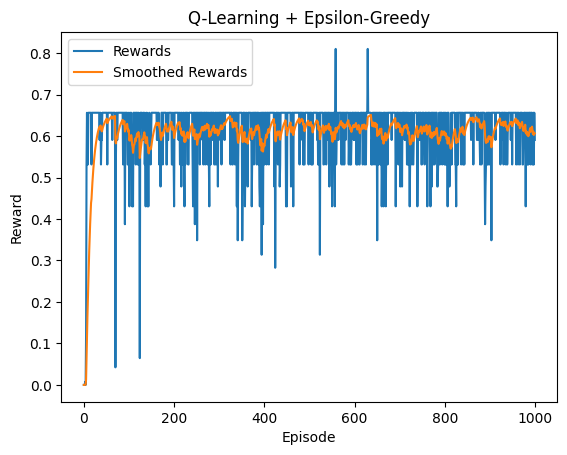

In [3]:
env = gym.make('games/GridWorld', max_episode_steps=50)
qfunction = QTable()
rewards = QLearning(env, EpsilonGreedy(), qfunction).execute(episodes=1000)
smoothed_rewards = get_ema(rewards)

plt.plot(rewards, label='Rewards')
plt.plot(smoothed_rewards, label='Smoothed Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.title('Q-Learning + Epsilon-Greedy')
plt.show()

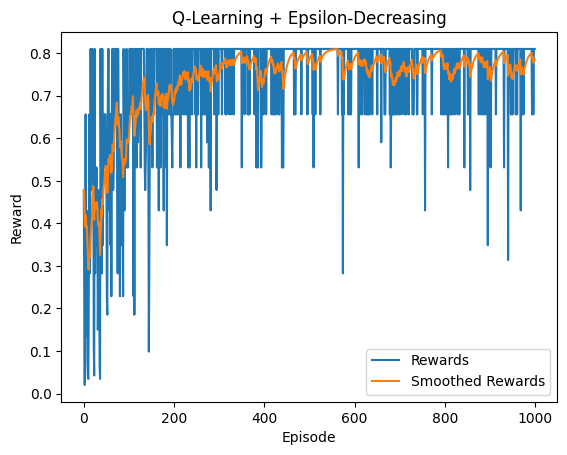

In [4]:
env = gym.make('games/GridWorld', max_episode_steps=50)
qfunction = QTable()
rewards = QLearning(env, EpsilonDecreasing(), qfunction).execute(episodes=1000)
smoothed_rewards = get_ema(rewards)

plt.plot(rewards, label='Rewards')
plt.plot(smoothed_rewards, label='Smoothed Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.title('Q-Learning + Epsilon-Decreasing')
plt.show()

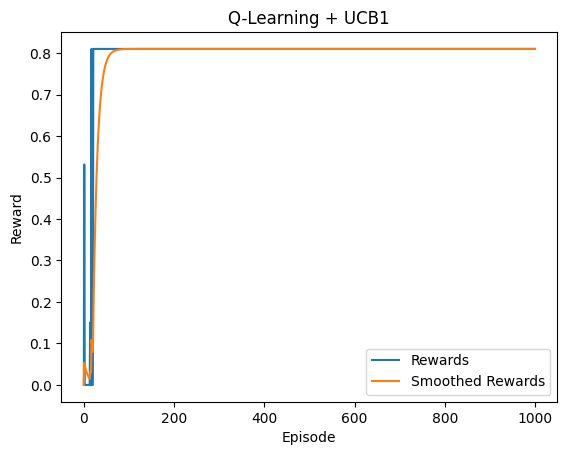

In [5]:
env = gym.make('games/GridWorld', max_episode_steps=50)
qfunction = QTable()
rewards = QLearning(env, UpperConfidenceBounds(), qfunction).execute(episodes=1000)
smoothed_rewards = get_ema(rewards)

plt.plot(rewards, label='Rewards')
plt.plot(smoothed_rewards, label='Smoothed Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.title('Q-Learning + UCB1')
plt.show()

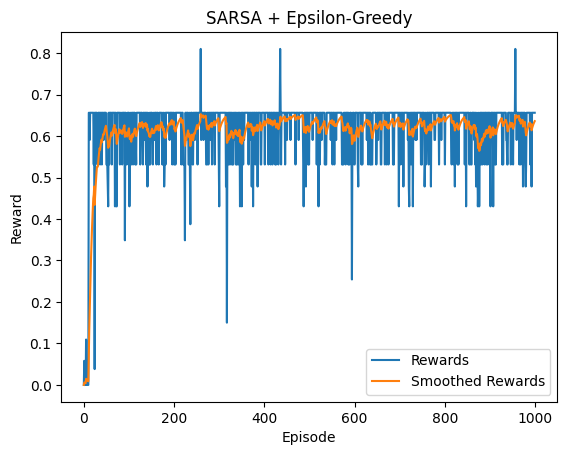

In [6]:
env = gym.make('games/GridWorld', max_episode_steps=50)
qfunction = QTable()
rewards = SARSA(env, EpsilonGreedy(), qfunction).execute(episodes=1000)
smoothed_rewards = get_ema(rewards)

plt.plot(rewards, label='Rewards')
plt.plot(smoothed_rewards, label='Smoothed Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.title('SARSA + Epsilon-Greedy')
plt.show()

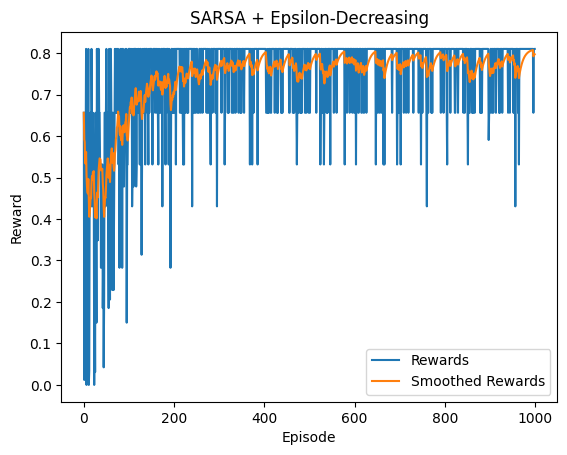

In [7]:
env = gym.make('games/GridWorld', max_episode_steps=50)
qfunction = QTable()
rewards = SARSA(env, EpsilonDecreasing(), qfunction).execute(episodes=1000)
smoothed_rewards = get_ema(rewards)

plt.plot(rewards, label='Rewards')
plt.plot(smoothed_rewards, label='Smoothed Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.title('SARSA + Epsilon-Decreasing')
plt.show()

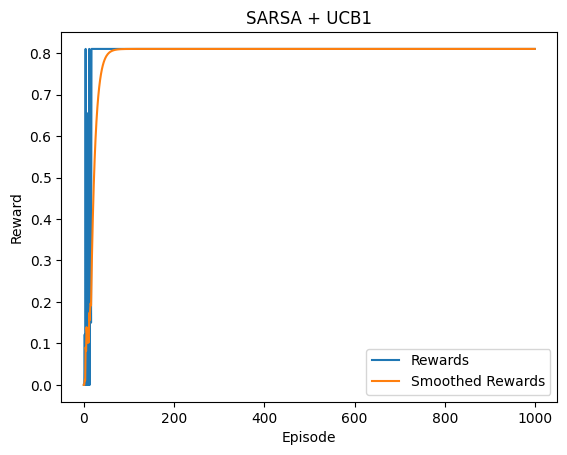

In [8]:
env = gym.make('games/GridWorld', max_episode_steps=50)
qfunction = QTable()
rewards = SARSA(env, UpperConfidenceBounds(), qfunction).execute(episodes=1000)
smoothed_rewards = get_ema(rewards)

plt.plot(rewards, label='Rewards')
plt.plot(smoothed_rewards, label='Smoothed Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.title('SARSA + UCB1')
plt.show()